In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
!pip install pycountry_convert
path = ''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
/kaggle/input/inf8245e-fall-2022/sample_submission.csv
/kaggle/input/inf8245e-fall-2022/train.csv
/kaggle/input/inf8245e-fall-2022/test.csv


## Import librairies

In [2]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('darkgrid')

# data preprocessing
import pycountry_convert as pc
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import tensorflow as tf

## Import CSV

In [3]:

train_df = pd.read_csv(f"{path}/kaggle/input/inf8245e-fall-2022/train.csv")
test_df  = pd.read_csv(f"{path}/kaggle/input/inf8245e-fall-2022/test.csv")
target = 'Concert Enjoyment'
x_train, y_train = train_df.drop(target, axis=1), train_df[target]
x_test = test_df.copy()

In [4]:
train_df.head()

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy


## Data Exploration

### Definition of usefull functions

In [5]:
def to_value_counts_df(df, col):
    df = pd.DataFrame(df[col].value_counts())
    df.index.name = col
    df.columns = ['count']
    return df

def countplot(df, col, ax=None):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df,
                    x=col,
                    palette='Blues_d',
                    order = df[col].value_counts().index,
                    ax=ax)
    ax.set_title(f'{col} value counts ({len(df[col].unique())} different values)')

def violinplot(df, col, ax=None):
    sns.violinplot(data=df, x=col, color='#1e3eae', ax=ax)
    ax.set_title(f'{col} distribution')

def display_correlation(df, ax=None):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(abs(corr), mask=mask, cmap='flare_r', square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f')

### Visualisation

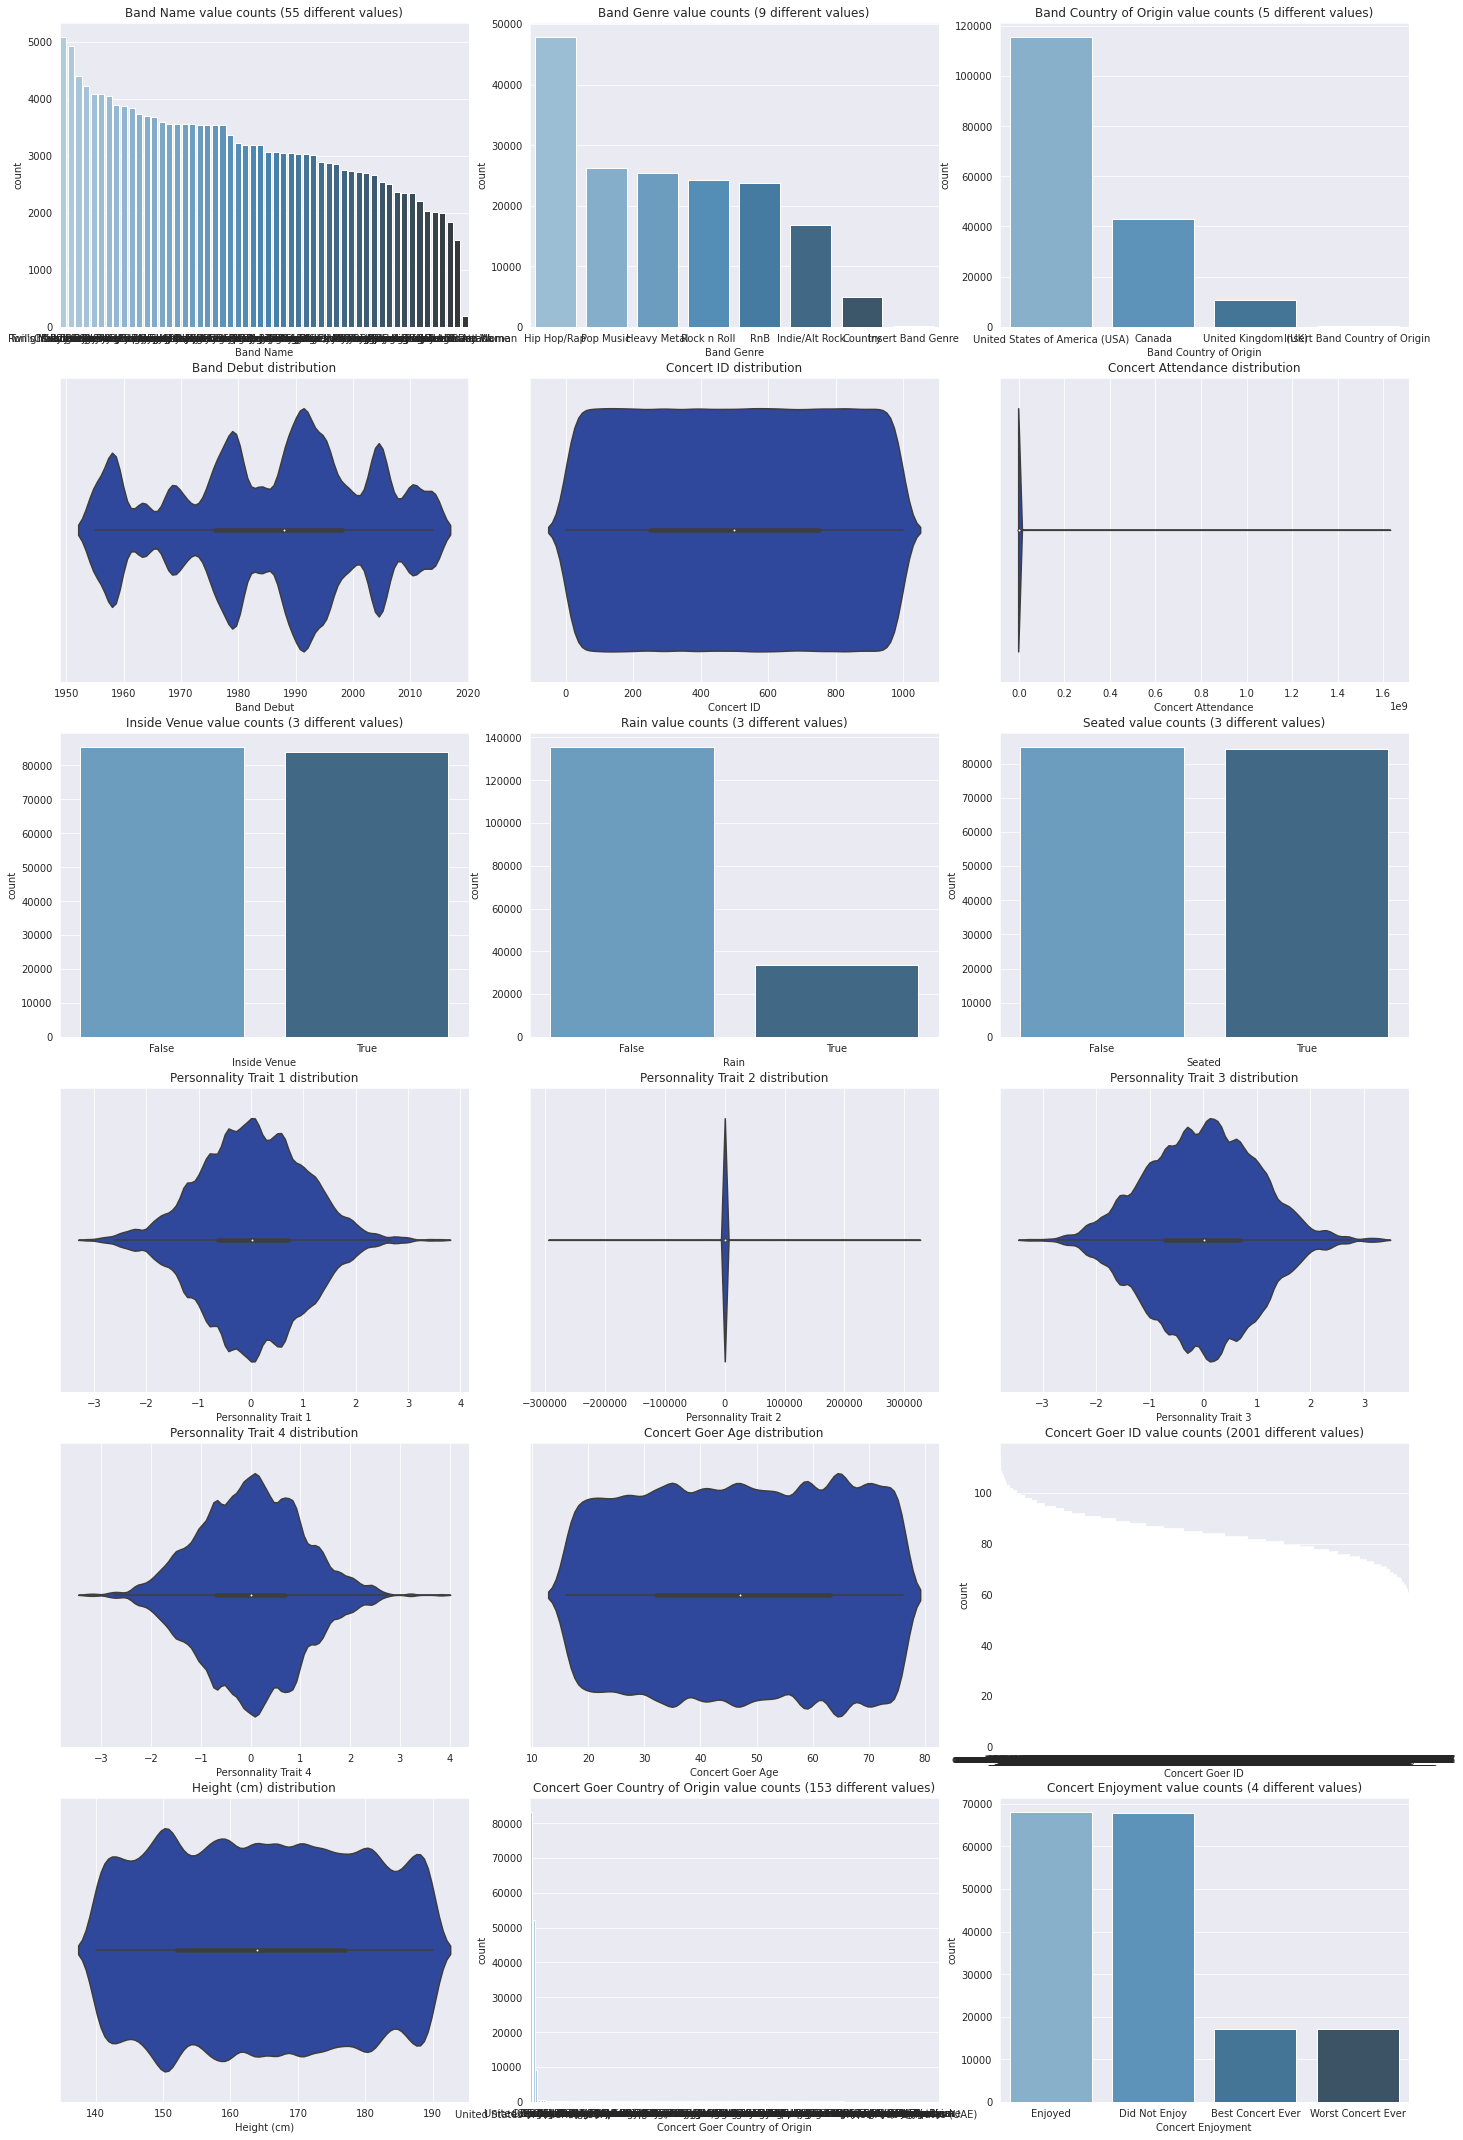

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [6]:
fig, axes = plt.subplots(6, 3, figsize=(20, 30))
fig.tight_layout(pad=3.0)
for i, col in enumerate(train_df.columns):
    if col =='Id':
        continue
    print(f"[{i}/{len(train_df.columns)-1}] {col}{' '*20}", end='\r')
    axe = axes[(i-1)//3, (i-1)%3]
    if train_df[col].dtype == object:
        countplot(train_df, col, axe)
    else:
        violinplot(train_df, col, axe)

[]

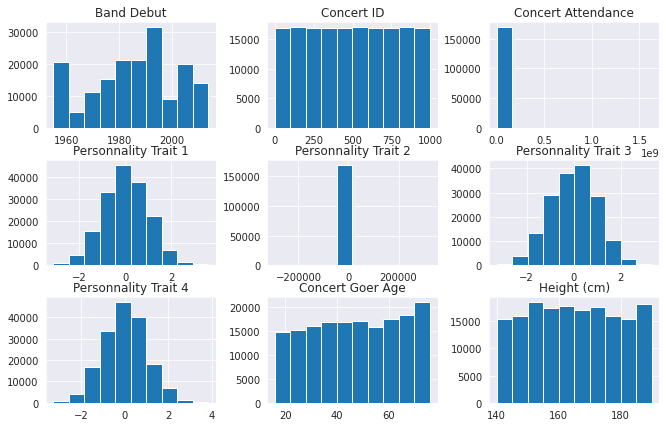

In [7]:
x_train._get_numeric_data().hist(figsize = (11, 7))
plt.plot()

<AxesSubplot:xlabel='Rain', ylabel='count'>

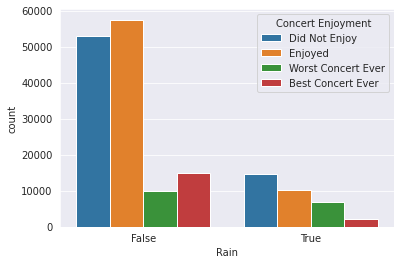

In [9]:
sns.countplot(
    data = train_df,
    x = "Rain",
    hue = "Concert Enjoyment"
)

### Correlation Matrix

[]

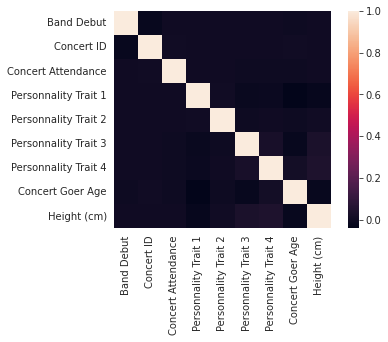

In [11]:
sns.heatmap(x_train.corr(), square = True)
plt.plot()

### Primary Component Analysis

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


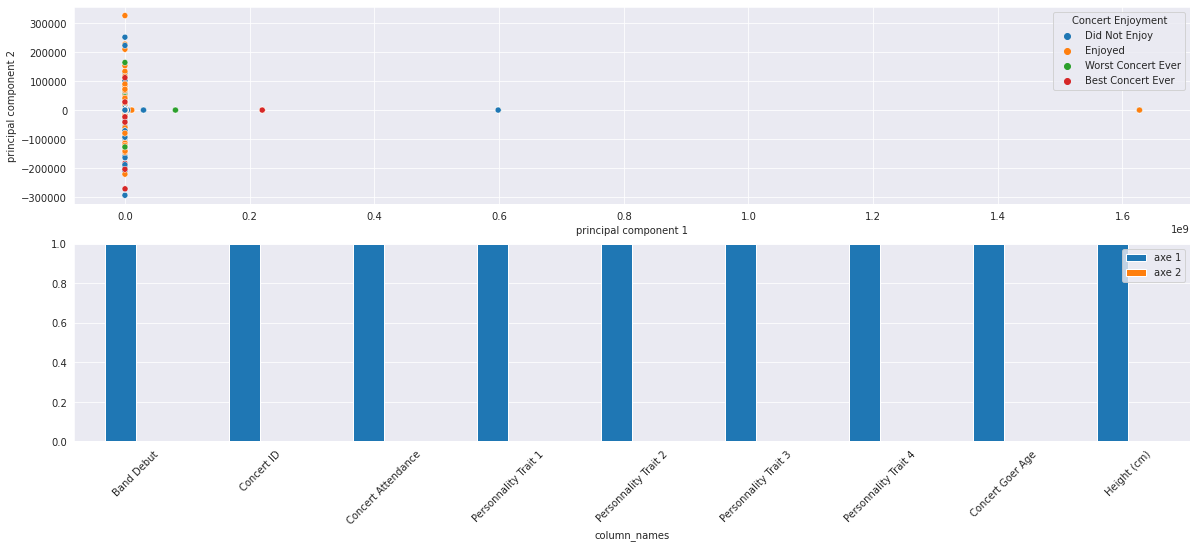

In [12]:
dimension = 2
pca = PCA(n_components=dimension)
numerical_data = train_df.select_dtypes(exclude='object')
numerical_data.dropna(axis=0, inplace=True)

principalComponents = pca.fit_transform(numerical_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f"principal component {i+1}" for i in range(dimension)])
finalDf = pd.concat([principalDf, train_df[[target]]], axis = 1)

colors = {
    'Worst Concert Ever': '#FF5D5D',
    'Did Not Enjoy': '#FFE3A9',
    'Enjoyed': '#00FFAB',
    'Best Concert Ever': '#14C38E',
}
finalDf['color'] = finalDf[target].apply(lambda x: colors[x])

fig, axes = plt.subplots(2, 1, figsize=(20, 10))
sns.scatterplot(data=finalDf, x='principal component 1', y='principal component 2', hue=target, ax=axes[0])
importances = dict()
importances['column_names'] = numerical_data.columns
for i in range(dimension):
    importances[f"axe {i+1}"] = pca.explained_variance_ratio_[i]
column_importances = pd.DataFrame(importances)
ax = column_importances.plot(x="column_names", y=[f"axe {i+1}" for i in range(dimension)], kind="bar",figsize=(20,8), ylim=(0,1), ax=axes[1])
for item in ax.get_xticklabels():
    item.set_rotation(45)

/opt/conda/lib/python3.7/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


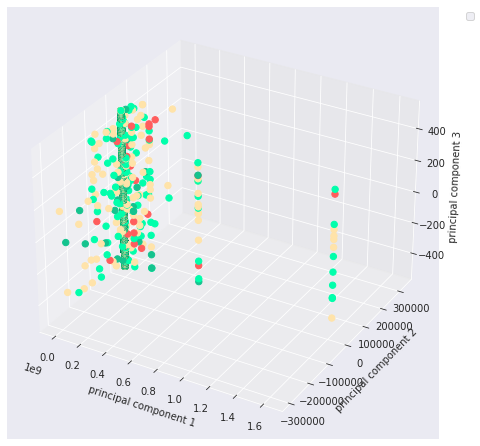

In [13]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(numerical_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, train_df[[target]]], axis = 1)

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


colors = {
    'Worst Concert Ever': '#FF5D5D',
    'Did Not Enjoy': '#FFE3A9',
    'Enjoyed': '#00FFAB',
    'Best Concert Ever': '#14C38E',
}
finalDf['color'] = finalDf[target].apply(lambda x: colors[x])

sc = ax.scatter(xs=finalDf['principal component 1'], ys=finalDf['principal component 2'], zs=finalDf['principal component 3'], c=finalDf['color'], s=40, marker='o', alpha=1)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

=> ACP analyzes do not allow us to distinguish enjoyment concerts easily.

In [14]:
train_df['Band Genre'].value_counts()

Hip Hop/Rap          47820
Pop Music            26175
Heavy Metal          25334
Rock n Roll          24193
RnB                  23748
Indie/Alt Rock       16858
Country               4907
Insert Band Genre       81
Name: Band Genre, dtype: int64

## Clean data

### Usefull functions

In [15]:
def linear_to_categorical(column, bins, labels):
    return pd.cut(column, bins=bins, labels=labels)

def categorical_to_linear(column, labels):
    return column.apply(lambda x: labels.index(x))

def manage_outliers(column, threshold=3):
    mean = column.mean()
    std = column.std()
    return column.apply(lambda x: x if abs(x-mean) < threshold*std else mean-std*threshold if x < mean else mean+std*threshold)

def replace_insert_by_nan(column):
    def replace_line(x):
        if pd.isna(x):
            return x
        elif 'Insert' in str(x):
            return np.nan
        return x
    return column.apply(replace_line)

def fill_na(column, categorical=False):
    if categorical:
        most_frequent = column.value_counts().index[0]
        return column.apply(lambda x: most_frequent if pd.isna(x) else x)
    else:
        mean = column.mean()
        return column.fillna(mean)

def fill_na_column_by_inference(df, column, groupby_column):
    most_common_value = df.groupby(groupby_column)[column].value_counts().groupby(groupby_column).idxmax().apply(lambda x: x[1])
    def fill_na_band(row):
        if pd.isna(row[column]):
            if row[groupby_column] in most_common_value:
                return most_common_value[row[groupby_column]]
            return np.nan
        else:
            return row[column]

    return df.apply(fill_na_band, axis=1)

def homogenize_column_by_inference(df, column, groupby_column):
    def homogenize_band(row):
        if row[groupby_column] in homogenized_columns:
            return homogenized_columns[row[groupby_column]]
        return row[column]

    homogenized_columns = df.groupby(groupby_column)[column].value_counts().groupby(groupby_column).idxmax().apply(lambda x: x[1])
    
    return df.apply(homogenize_band, axis=1)

def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

def robust_normalize(column):
    return (column - column.median()) / (column.quantile(0.75) - column.quantile(0.25))
    
def convert_to_one_hot_encode(column):
    return pd.get_dummies(column, prefix=column.name)

def remove_unrepresented_values(column, threshold=0.01):
    counts = column.value_counts(normalize=True)
    return column.apply(lambda x: 'other' if counts[x] < threshold else x)

def countries_to_continent(column):
    special_countries = {
        'United States of America (USA)': 'United States of America',
        'United Kingdom (UK)': 'United Kingdom',
        'United Arab Emirates (UAE)': 'United Arab Emirates',
        'Vatican City (Holy See)': 'Italy',
        'Central African Republic (CAR)': 'Central African Republic',
        'Congo, Democratic Republic of the': 'Congo',
        'Kosovo': 'Albania', # we take a country next to Kosovo
        'Timor-Leste': 'Indonesia', # we take a country next to Timor-Leste
        'Cote d\'Ivoire': 'Ivory Coast',
        'nan': 'United States of America', # default value
        'Insert Band Country of Origin': 'United States of America', # default value
    }

    def country_to_continents(country):
        if str(country) in special_countries:
            country = special_countries[str(country)]
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        return pc.country_alpha2_to_continent_code(country_code)

    return column.apply(country_to_continents)

def music_genres_to_tempo(column):
    tempos = {
        # cf https://www.musical-u.com/learn/rhythm-tips-for-identifying-music-genres-by-ear/
        'Hip Hop/Rap': (115+85)/2,
        'Pop Music': (123+100)/2,
        'Heavy Metal': (160+100)/2,
        'Rock n Roll': (140+100)/2,
        'RnB': (80+60)/2,
        'Indie/Alt Rock': (120+100)/2,
        'Country': (200+170)/2,
        'Insert Band Genre': np.nan,
        'nan': np.nan,
    }

    return column.apply(lambda x: tempos[str(x)])

def music_genres_similarity(column):
    proximity_with_rock = {
        # cf https://shouvikmani.github.io/Million-Song-Dataset-Visualization/index.html (genre proximity data taken for 2000)
        'Hip Hop/Rap'      : pd.Series([0.0731827062036,0.600156655464,0.257725289459,0.511263928879,0.484813723201,0.476994813899,0.272147998163,0.212153294265,0.620478693876,0.148659775026,0.149072897537,0.248085403816,1.0,0.745264107386,0.115199391357], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Pop Music'        : pd.Series([0.817776856646,0.218683822218,0.56536779265,0.463534198531,0.454461268241,0.243736526599,0.522440822771,0.750376395757,0.171509908819,0.293169783319,0.443491787207,1.0,0.295938784098,0.169091264364,0.684654472534], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Heavy Metal'      : pd.Series([0.377552719695,0.0,0.441454591437,0.568635287858,0.517427954299,0.17021989347,0.369669508312,0.217705784162,0.0249708478724,0.10078972596,1.0,0.345059480315,0.0622986431832,0.057628644206,0.890627091053], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Rock n Roll'      : pd.Series([0.703735427399,0.0991350986422,0.655135995599,0.378469386722,0.346463137186,0.0,0.55798209902,0.540765865935,0.0,0.218643703961,0.887826011449,0.61937320576,0.0,0.0,1.0], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'RnB'              : pd.Series([0.343014816013,1.0,0.690783796378,0.12594983717,0.169123684494,0.353142157322,0.725670696857,0.564394351754,0.834757593984,0.42953440297,0.054613489999,0.130706364602,0.583445854885,0.419385545213,0.169601285188], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Indie/Alt Rock'   : pd.Series([0.926675806184,0.565112112957,0.833968230414,0.113564504362,0.117987494728,0.190570619192,0.851604365445,1.0,0.475276887304,0.434397033862,0.26164821503,0.722726003819,0.180578940314,0.131369416172,0.577384937605], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Country'          : pd.Series([0.732377643818,0.651743753693,1.0,0.0,0.0,0.0155746365943,0.905985005781,0.812697291114,0.443030189263,0.601437900842,0.405290935741,0.455374139153,0.12907065459,0.115832081789,0.641976495601], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'Insert Band Genre': pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
        'nan'              : pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan], index=["alternative",'blues','country','dance','disco','electronic','folk','indie','jazz','latin','metal','pop','rap','reggae','rock']),
    }

    return column.apply(lambda x: proximity_with_rock[str(x)])

def music_genres_pct(df):
    index_to_take = {
        '1950s': 0,
        '1960s': 1,
        '1970s': 2,
        '1980s': 3,
        '1990s': 4,
        '2000s': 5,
        '2010s': 5,
        'nan'  : 0,
    }

    pct = {
        'Hip Hop/Rap':      [0.010, 0.011, 0.009, 0.016, 0.032, 0.029],
        'Pop Music':        [0.185, 0.191, 0.166, 0.193, 0.140, 0.145],
        'Heavy Metal':      [0.009, 0.021, 0.041, 0.061, 0.075, 0.074],
        'Rock n Roll':      [0.202, 0.252, 0.297, 0.270, 0.235, 0.210],
        'RnB':              [0.177, 0.159, 0.082, 0.042, 0.047, 0.023],
        'Indie/Alt Rock':   [0.014, 0.038, 0.065, 0.112, 0.148, 0.194],
        'Country':          [0.072, 0.053, 0.033, 0.026, 0.032, 0.022],
        'Insert Band Genre':[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
        'nan':              [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    }

    def get_pct(genre, year):
        return pct[str(genre)][index_to_take[str(year)]]
    
    return df.apply(lambda x: get_pct(x['Band Genre'], x['Band Debut cat']), axis=1)

def get_tokens_present_in_different_band_names(column):
    from nltk.corpus import stopwords
    band_names = column.value_counts().index
    tokens = [name.split() for name in band_names]
    tokens = list(set([item.lower() for sublist in tokens for item in sublist if len(item) > 2 and item not in stopwords.words('english')]))
    tokens = [token for token in tokens if len([name for name in band_names if token in name.lower()]) > 1]
    return tokens

def is_token_present_in_column(column, token):
    return column.apply(lambda x: 1 if token in x.lower() else 0)

### Cleaning

In [16]:
x_train, y_train = train_df.drop(target, axis=1), train_df[target]
x_to_clean = pd.concat([x_train, test_df.copy()], axis=0)
x_to_clean.drop(['Id', 'Concert Goer ID'], axis=1, inplace=True) #ID is useless

x_to_clean['Band Name'] = replace_insert_by_nan(x_to_clean['Band Name'])
x_to_clean['Band Name'] = fill_na_column_by_inference(x_to_clean, 'Band Name', 'Concert ID')
x_to_clean['Band Name'] = homogenize_column_by_inference(x_to_clean, 'Band Name', 'Concert ID')

x_to_clean['Band Debut'] = replace_insert_by_nan(x_to_clean['Band Debut'])
x_to_clean['Band Debut'] = fill_na_column_by_inference(x_to_clean, 'Band Debut', 'Band Name')
x_to_clean['Band Debut'] = homogenize_column_by_inference(x_to_clean, 'Band Debut', 'Band Name')

x_to_clean['Band Genre'] = replace_insert_by_nan(x_to_clean['Band Genre'])
x_to_clean['Band Genre'] = fill_na_column_by_inference(x_to_clean, 'Band Genre', 'Band Name')

x_to_clean['Rain'] = fill_na_column_by_inference(x_to_clean, 'Rain', 'Concert ID')

x_to_clean['Seated'] = fill_na_column_by_inference(x_to_clean, 'Seated', 'Concert ID') # we can't use Concert ID to infer Seated
x_to_clean['Concert Attendance'] = fill_na_column_by_inference(x_to_clean, 'Concert Attendance', 'Concert ID')
x_to_clean['Concert Attendance'] = homogenize_column_by_inference(x_to_clean, 'Concert Attendance', 'Concert ID')
x_to_clean['Inside Venue'] = fill_na_column_by_inference(x_to_clean, 'Inside Venue', 'Concert ID')
x_to_clean['Inside Venue'] = homogenize_column_by_inference(x_to_clean, 'Inside Venue', 'Concert ID')

x_to_clean['Concert ID'] = x_to_clean['Concert ID'].astype('object')
x_to_clean['Band Debut cat'] = linear_to_categorical(x_to_clean['Band Debut'], bins=[1950,1960,1970,1980,1990,2000,2010,2020], labels=['1950s','1960s','1970s','1980s','1990s','2000s','2010s'])
x_to_clean['Band Debut cat'] = x_to_clean['Band Debut cat'].astype('object')

x_to_clean['Concert Goer Age cat'] = linear_to_categorical(x_to_clean['Concert Goer Age'], bins=[10,20,30,40,50,60,70,90], labels=['10','20','30','40','50','60','70'])
x_to_clean['Concert Goer Age cat'] = x_to_clean['Concert Goer Age cat'].astype('object')

x_to_clean = pd.concat([x_to_clean, music_genres_similarity(x_to_clean['Band Genre'])], axis=1)
x_to_clean['Music Genre Pct'] = music_genres_pct(x_to_clean)

x_to_clean['Concert Attendance'] = np.log(x_to_clean['Concert Attendance'])

for column in x_to_clean._get_numeric_data().columns:
    x_to_clean[column] = fill_na(x_to_clean[column])
    x_to_clean[column] = robust_normalize(x_to_clean[column])

x_to_clean['Band Continent'] = countries_to_continent(x_to_clean['Band Country of Origin'])
x_to_clean['Concert Goer Continent'] = countries_to_continent(x_to_clean['Concert Goer Country of Origin'])

categoricals = []
for column in x_to_clean.select_dtypes(include='object').columns:
    x_to_clean[column] = fill_na(x_to_clean[column], categorical=True)
    first_item = x_to_clean[column].value_counts().index[0]
    categoricals.append((column, convert_to_one_hot_encode(x_to_clean[column]), f"{column}_{first_item}"))

tokens_band_name = get_tokens_present_in_different_band_names(x_to_clean['Band Name'])
for token in tokens_band_name:
    x_to_clean['Band Name contains ' + token] = is_token_present_in_column(x_to_clean['Band Name'], token)

x_to_clean = pd.concat((x_to_clean, *(c[1] for c in categoricals)), axis=1)
x_to_clean.drop([c[0] for c in categoricals], axis=1, inplace=True)

x_train = x_to_clean.iloc[:len(x_train)]
x_test = x_to_clean.iloc[len(x_train):]
print(f"Train shape: {x_train.shape}")
print(f"Test shape : {x_test.shape}")

Train shape: (170000, 1284)
Test shape : (30000, 1284)


In [17]:
x_train.head(1)

,Band Debut,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm),alternative,blues,...,Concert Goer Age cat_60,Concert Goer Age cat_70,Band Continent_EU,Band Continent_NA,Concert Goer Continent_AF,Concert Goer Continent_AS,Concert Goer Continent_EU,Concert Goer Continent_NA,Concert Goer Continent_OC,Concert Goer Continent_SA
0,-0.545455,0.0,0.229334,-0.692757,-0.681093,-1.186295,-0.6,-0.96,0.73748,0.0,...,0,0,0,1,0,0,0,0,0,1


## Models

In [18]:
def plot_confusion_matrix(y_true, y_pred):
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')
    confusion_matrix = confusion_matrix.reindex(['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'])[['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever']]
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.2f', annot_kws={"size": 16}, vmin=0, vmax=1)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Real Value')
    for i in range(confusion_matrix.shape[0] + 1):
        ax.axhline(i, color='white', lw=10)
    plt.show()

### Splitting data

In [19]:
nx_train, nx_test = train_test_split(x_train, test_size=0.01, random_state=42)
ny_train, ny_test = train_test_split(y_train, test_size=0.01, random_state=42)

print(f"Train shape: {nx_train.shape}")
print(f"Test shape : {nx_test.shape}")

Train shape: (168300, 1284)
Test shape : (1700, 1284)


### RandomForest

In [ ]:
"""
param_grid = {
    'max_depth': [10, 15, 20, 25, 30, 35, 40],
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(nx_train, ny_train)

print(grid_search.best_params_)
"""

With RandomForest, the F1 score is 0.64


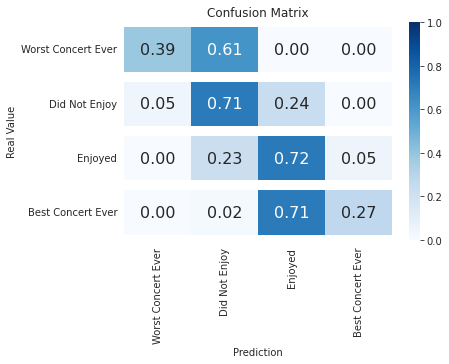

In [20]:

model = RandomForestClassifier(max_depth=40)
model.fit(nx_train, ny_train)

y_predict = model.predict(nx_test)

print(f"With RandomForest, the F1 score is {f1_score(ny_test, y_predict, average='micro')}")
plot_confusion_matrix(ny_test, y_predict)


### Neural Network

In [21]:
nyl_train = categorical_to_linear(ny_train, labels=['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'])
nyl_test = categorical_to_linear(ny_test, labels=['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'])

nnx_train, nnx_valid = train_test_split(nx_train, test_size=0.3, random_state=42)
nny_train, nny_valid = train_test_split(nyl_train, test_size=0.3, random_state=42)

#### Usefull functions

In [22]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric = tf.keras.metrics.SparseCategoricalAccuracy()

        self.val_accuracies = []
        self.test_accuracies = []
        self.test_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)

        self.metric.reset_states()
        
        y_pred = self.model.predict(self.x_test)
        self.metric.update_state(self.y_test, y_pred)
        self.test_accuracies.append(self.metric.result().numpy())
        self.val_accuracies.append(logs['sparse_categorical_accuracy'])
        self.test_losses.append(self.loss_fn(self.y_test, y_pred).numpy())
        self.val_losses.append(logs['loss'])

def plot_callback_history(callback):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(callback.val_accuracies, label='Train')
    ax[0].plot(callback.test_accuracies, label='Test')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(range(len(callback.val_accuracies)))
    ax[0].set_xlim(0, len(callback.val_accuracies) - 1)
    ax[0].set_xticklabels(range(1, len(callback.val_accuracies) + 1))
    ax[0].legend()
    ax[1].plot(callback.val_losses, label='Train')
    ax[1].plot(callback.test_losses, label='Test')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlim(0, len(callback.val_accuracies) - 1)
    ax[1].set_xticks(range(len(callback.val_losses)))
    ax[1].set_xticklabels(range(1, len(callback.val_losses) + 1))
    ax[1].legend()
    ax[0].get_shared_x_axes().join(ax[0], ax[1])

    plt.show()

<img alt="NN Shapes" src="https://www.mdpi.com/algorithms/algorithms-14-00051/article_deploy/html/images/algorithms-14-00051-g001.png" width=700>

#### Shape (C)

In [23]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(nnx_train.shape[1], 1)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.02),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4)
])
 
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['sparse_categorical_accuracy'],
              )
              

callback = TestCallback(nnx_valid, nny_valid)
model.fit(nnx_train, nny_train, batch_size = 5000, epochs = 20, callbacks=[callback])

2022-12-05 01:21:39.018153: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-05 01:21:41.835259: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
24/24 [==============================] - 4s 139ms/step - loss: 1.8059 - sparse_categorical_accuracy: 0.4996
Epoch 2/20
24/24 [==============================] - 3s 136ms/step - loss: 1.2267 - sparse_categorical_accuracy: 0.6004
Epoch 3/20
24/24 [==============================] - 4s 164ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.6123
Epoch 4/20
24/24 [==============================] - 3s 142ms/step - loss: 0.9866 - sparse_categorical_accuracy: 0.6206
Epoch 5/20
24/24 [==============================] - 3s 142ms/step - loss: 0.9449 - sparse_categorical_accuracy: 0.6303
Epoch 6/20
24/24 [==============================] - 3s 137ms/step - loss: 0.8619 - sparse_categorical_accuracy: 0.6363
Epoch 7/20
24/24 [==============================] - 3s 138ms/step - loss: 0.8281 - sparse_categorical_accuracy: 0.6408
Epoch 8/20
24/24 [==============================] - 3s 138ms/step - loss: 0.8085 - sparse_categorical_accuracy: 0.6444
Epoch 9/20
24/24 [==============================

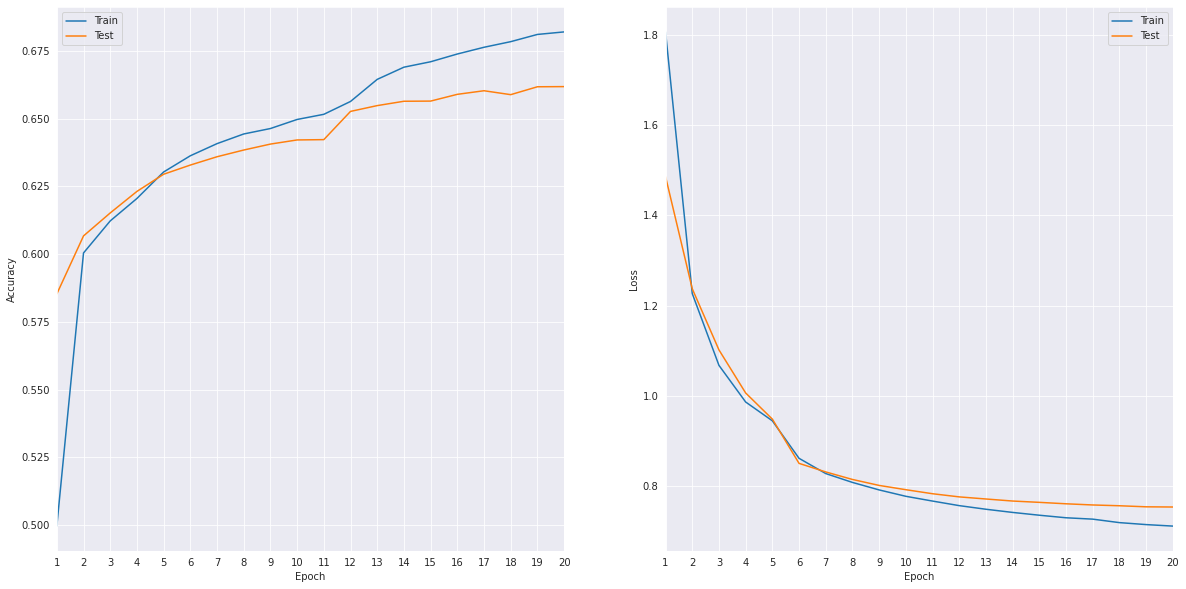

In [24]:
plot_callback_history(callback)

54/54 - 0s - loss: 0.7604 - sparse_categorical_accuracy: 0.6647


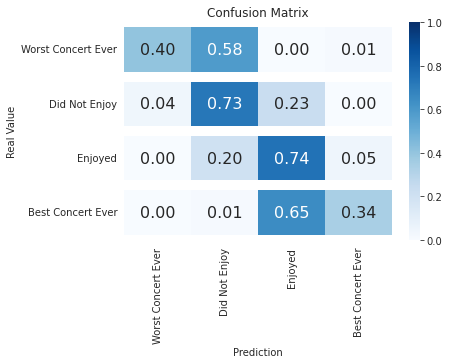

In [25]:
model.evaluate(nx_test,  nyl_test, verbose=2)
y_predict = model.predict(nx_test)
y_predict = np.argmax(y_predict, axis=1)
y_predict = linear_to_categorical(y_predict, bins=[-1,0,1,2,3], labels=['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'])
plot_confusion_matrix(ny_test, y_predict)

In [26]:

r = model.predict(x_test)
y_target = np.argmax(r, axis=1)

## Generation of submit file

In [27]:
# y_target = model.predict(x_test)

# y_target = y_target.round().astype(int)
y_target = linear_to_categorical(y_target, bins=[-1,0,1,2,3], labels=['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever'])

targetDF = pd.DataFrame({ 'Id': test_df['Id'], 'Predicted': y_target })
targetDF = targetDF.set_index('Id')
targetDF.to_csv('output_final.csv')
targetDF.head()

,Predicted
Id,
ConcertExperience_70055,Best Concert Ever
ConcertExperience_34799,Enjoyed
ConcertExperience_100410,Enjoyed
ConcertExperience_106446,Enjoyed
ConcertExperience_127249,Did Not Enjoy
